<a href="https://colab.research.google.com/github/vrlnarayana/capstone-gl/blob/main/Capstone_Recommendation_Systems_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project : Group 4 : Song Recommendation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from google.colab import files
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format   

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

**READ SONG DATA**

In [5]:
song_data=pd.read_csv(r'/content/drive/My Drive/song_data.csv')

**READ PLAY COUNT DATA**

In [6]:
count_data=pd.read_csv(r'/content/drive/My Drive/count_data.csv', index_col='Unnamed: 0') #Making unnamed: 0 an index column

**READ IMDb RATING DATA - "Externally Added"**

In [7]:
df_rating_data=pd.read_csv(r'/content/drive/My Drive/rating data.tsv', sep='\t')

**READ IMDb MOVIE TITLES DATA - "Externally Added"**

In [8]:
df_akas_data=pd.read_csv(r'/content/drive/My Drive/akas data.tsv', sep='\t')

In [9]:
song_data.head()

song_id              title  ...       artist_name  year
0  SOQMMHC12AB0180CB8       Silent Night  ...  Faster Pussy cat  2003
1  SOVFVAK12A8C1350D9        Tanssi vaan  ...  Karkkiautomaatti  1995
2  SOGTUKN12AB017F4F1  No One Could Ever  ...    Hudson Mohawke  2006
3  SOBNYVR12A8C13558C      Si Vos Querés  ...       Yerba Brava  2003
4  SOHSBXH12A8C13B0DF   Tangle Of Aspens  ...        Der Mystic     0

[5 rows x 5 columns]

In [10]:
count_data.head()

user_id             song_id  play_count
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995           1
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B           2
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBXHDL12A81C204C0           1
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBYHAJ12A6701BF1D           1
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODACBL12A8C13C273           1

In [11]:
df_rating_data.head()

tconst  averageRating  numVotes
0  tt0000001           5.60      1668
1  tt0000002           6.10       207
2  tt0000003           6.50      1392
3  tt0000004           6.20       123
4  tt0000005           6.20      2179

In [12]:
df_akas_data.head()

titleId  ordering  ...     attributes isOriginalTitle
0  tt0000001         1  ...             \N               0
1  tt0000001         2  ...  literal title               0
2  tt0000001         3  ...             \N               0
3  tt0000001         4  ...             \N               0
4  tt0000001         5  ...             \N               0

[5 rows x 8 columns]

**COMMENT:**
millionsongs dataset and IMDb have different indexes/keys and hence we need to analyse and see how to join based on common movie title. If there is no match, we need to find an alternate solution

# Exploratory data Analysis

In [13]:
count_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   song_id     object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 61.0+ MB


In [14]:
song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


**COMMENTS**
1.   year and paly_count are an int column in song_data and count_data
2.   **15 titles and 5 releases are null values**



In [15]:
rows, columns = count_data.shape
print("No of rows: ", rows) 
print("No of columns: ", columns)

No of rows:  2000000
No of columns:  3


In [16]:
rows, columns = song_data.shape
print("No of rows: ", rows) 
print("No of columns: ", columns)

No of rows:  1000000
No of columns:  5


In [17]:
count_data.describe()

play_count
count 2,000,000.00
mean          3.05
std           6.58
min           1.00
25%           1.00
50%           1.00
75%           3.00
max       2,213.00

In [18]:
song_data.describe()

year
count 1,000,000.00
mean      1,030.33
std         998.75
min           0.00
25%           0.00
50%       1,969.00
75%       2,002.00
max       2,011.00

**COMMENT:**
**Song data has some year values 0, which may not be useful in the analysis**



In [19]:
df_rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106685 entries, 0 to 1106684
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1106685 non-null  object 
 1   averageRating  1106685 non-null  float64
 2   numVotes       1106685 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 25.3+ MB


In [20]:
df_akas_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24662400 entries, 0 to 24662399
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   titleId          object
 1   ordering         int64 
 2   title            object
 3   region           object
 4   language         object
 5   types            object
 6   attributes       object
 7   isOriginalTitle  object
dtypes: int64(1), object(7)
memory usage: 1.5+ GB


In [21]:
df_rating_data.describe()

averageRating     numVotes
count   1,106,685.00 1,106,685.00
mean            6.88       954.49
std             1.41    15,978.59
min             1.00         5.00
25%             6.10         9.00
50%             7.10        20.00
75%             7.90        78.00
max            10.00 2,324,072.00

**COMMENTS:**
1.   AverageRating has **rating 1 to 10.**
2.   numVotes shows a **huge SKEW**



In [22]:
song_data.isnull().sum()

song_id         0
title          15
release         5
artist_name     0
year            0
dtype: int64

**COMMENT**
**In Song data 15 titles and 5 releases are null values**

In [23]:
print('No of unique artists in the data=> ',song_data.artist_name.nunique())

No of unique artists in the data=>  72665


In [24]:
count_data.isnull().sum()

user_id       0
song_id       0
play_count    0
dtype: int64

**COMMENT**
**Play Count data has no null values**

# Checking Duplicates in Song Data

In [25]:
song_data.duplicated().value_counts()

False    999502
True        498
dtype: int64

**COMMENT**
**Song data has 498 duplicates**, we will have treat duplicates before grouping and analysing data

In [26]:
count_data.duplicated().any()

False

**COMMENTS**
**Count data has no duplicates**

In [27]:
# Checking for duplicated rows in song data
song_data[song_data.duplicated()] #Duplicates are 498 in count

song_id  ...  year
18309   SOPFBUZ12AF729C896  ...  2003
32760   SOJHKXX12A8C139798  ...  2004
54218   SONVJUL12A6701FB7A  ...  2005
73174   SORBGBD12A8C141CEA  ...  2006
83415   SONLOQQ12A8C139AF9  ...  2003
...                    ...  ...   ...
997476  SOCGXXL12B0B808865  ...  1991
998785  SOEUIVS12A8C1400E3  ...  1992
999365  SORANLE12A6310DBC8  ...     0
999643  SOAPUFN12AB017FF03  ...  1998
999740  SODNVTM12A6D4FA448  ...     0

[498 rows x 5 columns]

In [28]:
# Checking a sample data
song_data[song_data.song_id=='SOPFBUZ12AF729C896']

song_id           title      release  artist_name  year
7055   SOPFBUZ12AF729C896  Spitting Games  Final Straw  Snow Patrol  2003
18309  SOPFBUZ12AF729C896  Spitting Games  Final Straw  Snow Patrol  2003

# Treating Duplicates in Song Data

In [29]:
# DROPPING DUPLICATES in SONG DATA with inplace=True
song_data.drop(song_data[song_data.duplicated()].index, inplace=True)

In [30]:
# CHECKING DUPLICATES AGAIN TO CONFIRM
song_data.duplicated().any()

False

# Checking null values in song title and release column

In [31]:
nan_song_df=song_data[song_data.title.isnull() | song_data.release.isnull()]
nan_song_df

song_id                     title  ...     artist_name year
64262   SOVICLT12A58A7C4D0                       NaN  ...          Milton    0
114672  SOAGRAA12AB018D567                       NaN  ...  Sébastien Roch    0
138011  SOOBGAQ12A6D4F6762                  Solitude  ...           Metro    0
197822  SOGFJER12A6D4F675F  All The Beautiful People  ...           Metro    0
223019  SOAFJBH12A6D4F6765           Down The Aisles  ...           Metro    0
229353  SOOAFJX12AB018A028                       NaN  ...  Sébastien Roch    0
264639  SOLDTFD12AB018AFE6                       NaN  ...  Sébastien Roch    0
458083  SOAUTVB12AB018AFF0                       NaN  ...  Sébastien Roch    0
557125  SOMPGYE12AB018AFE0                       NaN  ...  Sébastien Roch    0
578241  SOVHAZH12AB018D5B3                       NaN  ...  Sébastien Roch    0
652287  SOECGBQ12AB018D582                       NaN  ...  Sébastien Roch    0
693232  SOCKQGJ12A6D4F6768                Provincial  ...           Metro    0
697789  SOTJWHR12AB018D5A0                       NaN  ...  Sébastien Roch    0
697813  SOBDDHR12AB01888A6                       NaN  ...          Remute    0
725270  SOFDILP12AC960A4EF                       NaN  ...           Fobia    0
795481  SOSFNKO12AB018D5BB                       NaN  ...  Sébastien Roch    0
841107  SOSQKYC12A6D4F6763                 Middlemen  ...           Metro    0
853170  SOASSAS12AB018AFCF                       NaN  ...  Sébastien Roch    0
857992  SOZDBDL12AB018AFFF                       NaN  ...  Sébastien Roch    0
925868  SOQUGMS12AB018B01D                       NaN  ...  Sébastien Roch    0

[20 rows x 5 columns]

**Checking null values in song title and release has any impact on play count data**
**If there is no play count data available for the Null titles and releases then we can ignore them as they will not impact our analysis** 

In [32]:
count_data.song_id.isin(nan_song_df.song_id).value_counts() 

False    2000000
Name: song_id, dtype: int64

**COMMENT:**
value_counts provides a False output which means there is **NO IMPACT** null titles do not have play counts. Hence, **IGNORE THEM NULL TITLES and RELEASES**

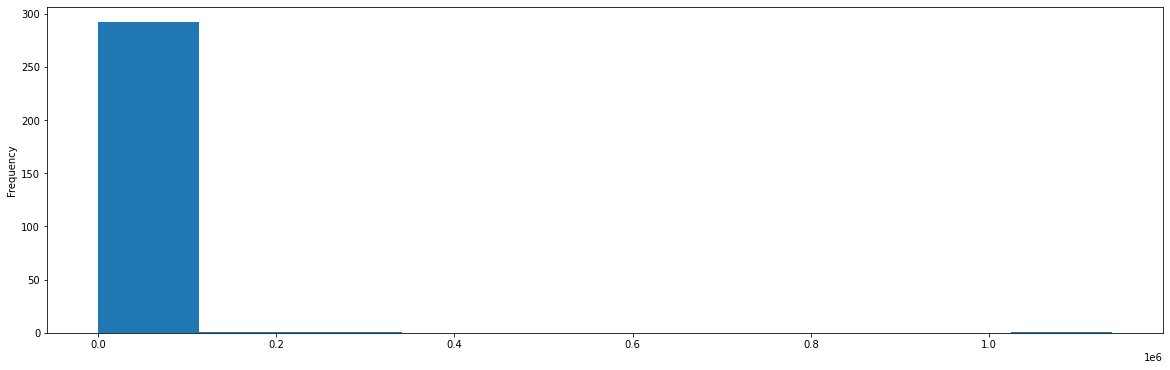

In [33]:
#HIST plot to see the concentration of user play_counts. We can see the count is more in the lower rungs, with an exception of a few in the higher rungs
count_data.play_count.value_counts().plot(bins=10,kind='hist')

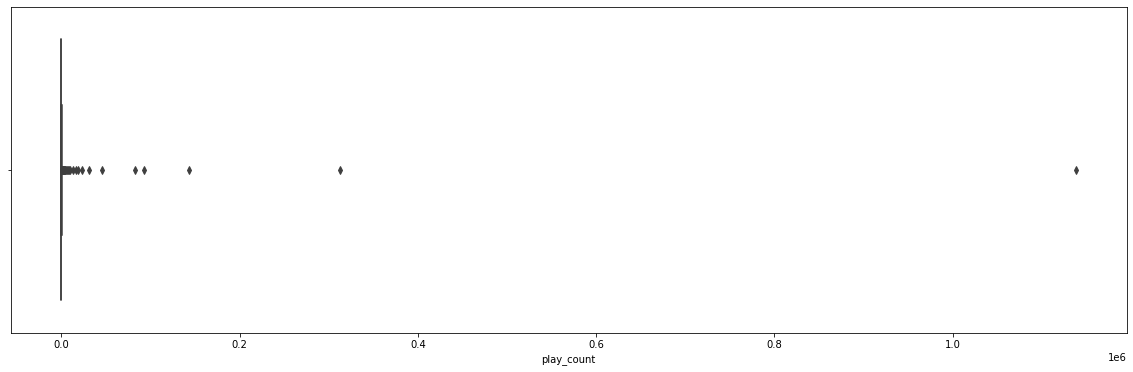

In [34]:
# Confirming the same with boxplot
sns.boxplot(count_data.play_count.value_counts())

# Grouping and Merging DataSets

In [35]:
sorted_play_counts_df=count_data.groupby(['song_id','play_count']).sum().sort_values(by='play_count',ascending=False)
sorted_play_counts_df.reset_index(inplace=True)
sorted_play_counts_df.set_index('song_id', inplace=True)# making song_id index of the df, this is required to merge with song_data df

sorted_play_counts_df # Sorted in descending order of play_count to see the top play counts first


play_count                                            user_id
song_id                                                                          
SOFCGSE12AF72A674F        2213           d13609d62db6df876d3cc388225478618bb7b912
SOUAGPQ12A8AE47B3A         920           50996bbabb6f7857bf0c8019435b5246a0e45cfd
SOKOSPK12A8C13C088         879           5ea608df0357ec4fda191cb9316fe8e6e65e3777
SOZQSVB12A8C13C271         796           bb85bb79612e5373ac714fcd4469cabeb5ed94e1
SOBONKR12A58A7A7E0         683           c012ec364329bb08cbe3e62fe76db31f8c5d8ec3
...                        ...                                                ...
SOPRQRO12AB018906E           1  25fc0200450bbf726c8511fabe31ecfdb81732eb3fd3ac...
SOPROPB12A8C1385BD           1  732f88be38fae217f8ab7e24c20dd072436e3e40b12c78...
SOPROEW12A6D4FD0F7           1  4691b4c353503da2c108e372ff056a9ac847c4d1fb51c7...
SOPRNPL12A6D4FD323           1  ed789db32c9ccb59fb75e04a2b923b0f4777ae07b055b6...
SOMTXSB12AF72ACC38           1  685480702e45a90a3b38b543941d8ebb422aeef38f0e25...

[140228 rows x 2 columns]

In [36]:
songs_play_count_df=pd.merge(sorted_play_counts_df,song_data,on='song_id')

In [37]:
songs_play_count_df

song_id  play_count  ...         artist_name  year
0       SOFCGSE12AF72A674F        2213  ...            Gorillaz  2000
1       SOFCGSE12AF72A674F          26  ...            Gorillaz  2000
2       SOFCGSE12AF72A674F           9  ...            Gorillaz  2000
3       SOFCGSE12AF72A674F           7  ...            Gorillaz  2000
4       SOFCGSE12AF72A674F           6  ...            Gorillaz  2000
...                    ...         ...  ...                 ...   ...
142485  SOSVQPX12A8C14078C           1  ...  Neutral Milk Hotel  1996
142486  SOSLEFC12A6D4FC740           2  ...       Reel Feelings     0
142487  SOSLEFC12A6D4FC740           1  ...       Reel Feelings     0
142488  SOXDPFW12A81C2319B           2  ...            Four Tet  2008
142489  SOXDPFW12A81C2319B           1  ...            Four Tet  2008

[142490 rows x 7 columns]

**COMMENT**
**songs_play_count_df has total rows of 142490 rows afer pd merge**

In [38]:
songs_play_count_df.isnull().any() # reconfirming presence of any null values.

song_id        False
play_count     False
user_id        False
title          False
release        False
artist_name    False
year           False
dtype: bool

**There are no null values**

In [39]:
songs_play_count_df[songs_play_count_df['song_id']=='SOBONKR12A58A7A7E0']

song_id  play_count  ...    artist_name  year
89   SOBONKR12A58A7A7E0         683  ...  Dwight Yoakam  1990
90   SOBONKR12A58A7A7E0         446  ...  Dwight Yoakam  1990
91   SOBONKR12A58A7A7E0         359  ...  Dwight Yoakam  1990
92   SOBONKR12A58A7A7E0         271  ...  Dwight Yoakam  1990
93   SOBONKR12A58A7A7E0         225  ...  Dwight Yoakam  1990
..                  ...         ...  ...            ...   ...
199  SOBONKR12A58A7A7E0           5  ...  Dwight Yoakam  1990
200  SOBONKR12A58A7A7E0           4  ...  Dwight Yoakam  1990
201  SOBONKR12A58A7A7E0           3  ...  Dwight Yoakam  1990
202  SOBONKR12A58A7A7E0           2  ...  Dwight Yoakam  1990
203  SOBONKR12A58A7A7E0           1  ...  Dwight Yoakam  1990

[115 rows x 7 columns]

**COMMENT:**
specific song_id = **SOFCGSE12AF72A674F** show that a user_id = **d13609d62db6df876d3cc388225478618bb7b912** has played it 2213 times, must be a crazy listner as the next best is only 26

In [40]:
# Release'wise sorted play count (Top 10)
release_play_count_df=songs_play_count_df[['release','play_count']].groupby('release').sum().sort_values(by='play_count',ascending=False)[:10]
release_play_count_df

play_count
release                       
Greatest Hits            14288
If There Was A Way        9224
Only By The Night         9106
My Worlds                 7605
Vespertine Live           6225
Fat Come Back             5149
Fallen                    4945
Fearless                  4872
Waking Up                 4678
Lungs                     4643

In [41]:
# Artist'wise play count top 10
artist_play_count_df=songs_play_count_df[['artist_name','play_count']].groupby('artist_name').sum().sort_values(by='play_count',ascending=False)[:10]
artist_play_count_df

play_count
artist_name               
Kings Of Leon        12999
The Black Keys       12408
Coldplay             11717
Muse                 10316
Taylor Swift          9601
Jack Johnson          9557
Justin Bieber         9448
Dwight Yoakam         9224
Metallica             8568
Gorillaz              8397

In [42]:
# artist and release 'wise top 10
artist_release_play_count_df=songs_play_count_df[['artist_name','release','play_count']].groupby(['artist_name','release']).sum().sort_values(by='play_count',ascending=False)[:10]
artist_release_play_count_df

play_count
artist_name            release                       
Dwight Yoakam          If There Was A Way        9224
Kings Of Leon          Only By The Night         9106
Justin Bieber          My Worlds                 6807
Björk                  Vespertine Live           6225
Alliance Ethnik        Fat Come Back             5149
Evanescence            Fallen                    4945
OneRepublic            Waking Up                 4678
Florence + The Machine Lungs                     4643
Taylor Swift           Fearless                  4510
Sam Cooke              Summertime                4463

# Filtering songs data based on top play counts

In [43]:
top_count_data=count_data[count_data.play_count>20] # considering play_count greater than 20

In [44]:
print('The number of observations in top_count_data =', len(top_count_data))
print('Number of unique USERS in top_count_data = ', top_count_data['user_id'].nunique())
print('Number of unique SONGS in top_count_data = ', top_count_data['song_id'].nunique())

The number of observations in top_count_data = 31141
Number of unique USERS in top_count_data =  13581
Number of unique SONGS in top_count_data =  6599


# Popularity based recommendation

In [45]:
popular_song_df = top_count_data.groupby('song_id').play_count.agg(['sum']).sort_values(by='sum',ascending=False)
popular_song_df.head(10) #Popularity based top 10 songs played. 
 # TO be discussed with Lakshminaryanan

sum
song_id                  
SOBONKR12A58A7A7E0  27776
SOAUWYT12A81C206F1  21616
SOSXLTC12AF72A7F54  19225
SOEGIYH12A6D4FC0E3  12571
SOUFTBI12AB0183F65   9483
SOVDSJC12A58A7A271   8299
SOPUCYA12A8C13A694   7814
SOOFYTN12A6D4F9B35   7590
SOHTKMO12AB01843B0   6522
SOTCMDJ12A6D4F8528   6062

In [46]:
# Making a dataframe where we have summation of times song is played in general and played by distincet users i.e count_play_count.(Number of times we have play_count for the users)
sum_play_count = songs_play_count_df.groupby('song_id').sum()['play_count']
count_play_count = songs_play_count_df.groupby('song_id').count()['play_count']
final_play_count=pd.DataFrame({'sum_play_count':sum_play_count,'count_play_count':count_play_count})

In [47]:
final_play_count.sort_values(by='count_play_count', ascending=False)

sum_play_count  count_play_count
song_id                                             
SOBONKR12A58A7A7E0            9224               115
SOSXLTC12AF72A7F54            8153               107
SOAUWYT12A81C206F1            6097               100
SOJRFWQ12AB0183582            3861                96
SOEGIYH12A6D4FC0E3            4397                87
...                            ...               ...
SOPJWVJ12A6D4FA182               6                 3
SOPQGWI12A8C135DDB               6                 3
SOOEJDW12A8C139EF1               6                 3
SOXDPFW12A81C2319B               3                 2
SOSLEFC12A6D4FC740               3                 2

[10000 rows x 2 columns]

In [48]:
#defining a function to get the top n songs based on highest times a song is played in general and some minimum interactions (minimum number of distinct users or we can say play count) of that song
def top_n_songs(final_play_count, n, min_interaction=50):
    recommendations=final_play_count[final_play_count['count_play_count']>min_interaction]
    recommendations=recommendations.sort_values(by='sum_play_count', ascending=False)
    return recommendations.index[:n]

In [49]:
# Top 5 songs based on atleast 50 interactions between users and the song. 
top_pop_songs_id=list(top_n_songs(final_play_count, 10, 50))
top_pop_songs_id

['SOBONKR12A58A7A7E0',
 'SOSXLTC12AF72A7F54',
 'SOAUWYT12A81C206F1',
 'SOVDSJC12A58A7A271',
 'SOEGIYH12A6D4FC0E3',
 'SOUFTBI12AB0183F65',
 'SOJRFWQ12AB0183582',
 'SOOFYTN12A6D4F9B35',
 'SOTCMDJ12A6D4F8528',
 'SOUDLVN12AAFF43658']

In [50]:
song_data[song_data.song_id.isin(top_pop_songs_id)].set_index('song_id').title

song_id
SOAUWYT12A81C206F1                                                 Undo
SOOFYTN12A6D4F9B35                                           Représente
SOVDSJC12A58A7A271                                     Ain't Misbehavin
SOJRFWQ12AB0183582                                         Dance_ Dance
SOTCMDJ12A6D4F8528                                             The Gift
SOUFTBI12AB0183F65                                              Invalid
SOBONKR12A58A7A7E0                                       You're The One
SOEGIYH12A6D4FC0E3    Horn Concerto No. 4 in E flat K495: II. Romanc...
SOUDLVN12AAFF43658                               Make Love To Your Mind
SOJRFWQ12AB0183582                                         Dance_ Dance
SOSXLTC12AF72A7F54                                              Revelry
SOJRFWQ12AB0183582                                         Dance_ Dance
Name: title, dtype: object

In [51]:
choices=np.unique(song_data[song_data.song_id.isin(top_pop_songs_id)].title.values)+' by '+np.unique(song_data[song_data.song_id.isin(top_pop_songs_id)].artist_name.values)

In [52]:
choices,len(choices)

(array(["Ain't Misbehavin by Alliance Ethnik",
        'Dance_ Dance by Angels and Airwaves',
        'Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) by Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner',
        'Invalid by Bill Withers', 'Make Love To Your Mind by Björk',
        'Représente by Dwight Yoakam', 'Revelry by Fall Out Boy',
        'The Gift by Kings Of Leon', 'Undo by Sam Cooke',
        "You're The One by Tub Ring"], dtype=object), 10)

# Collaborative filtering based recommendation

**Interaction Matrix - play_count_data**

In [53]:
play_count_data_matrix = top_count_data.pivot(index='user_id', columns='song_id', values='play_count').fillna(0)
play_count_data_matrix

song_id                                   SOAAAGQ12A8C1420C8  ...  SOZZWZV12A67AE140F
user_id                                                       ...                    
00125672fad06bc57f5a4304cceea9effab07839                0.00  ...                0.00
0013e651c18f10396ad1125d5d1c894b0224bb1f                0.00  ...                0.00
0021d9a4628624f6d70237f9c200ab82e766bf26                0.00  ...                0.00
0022c3932761ce91d8a034318402cfb63224f894                0.00  ...                0.00
002543003041db1d049206b09426d5cdffc0f451                0.00  ...                0.00
...                                                      ...  ...                 ...
ffe2f99d7f8b034a21fafdc2bb859d3c151d3950                0.00  ...                0.00
ffe50146303f1b12ea8254450b95580b1b99a5c4                0.00  ...                0.00
ffecbb84f3dde31b0b2e64d70b7b7e5092bf7427                0.00  ...                0.00
ffed85afa9c1eccf05660065400d998000e2e04f                0.00  ...                0.00
fff03efd1550136063389fa71125194614e1c68f                0.00  ...                0.00

[13581 rows x 6599 columns]

In [54]:
available_play_counts = np.count_nonzero(play_count_data_matrix)
print('available_play_counts = ', available_play_counts)
possible_num_of_play_counts = play_count_data_matrix.shape[0] * play_count_data_matrix.shape[1]
print('possible_num_of_play_counts = ', possible_num_of_play_counts)
density = (available_play_counts/possible_num_of_play_counts)
density *= 100
print ('density: {:4.2f}%'.format(density))

available_play_counts =  31141
possible_num_of_play_counts =  89621019
density: 0.03%


**COMMENT:**
**Density is low, means data is sparse**

# Merge IMDb with Song Data

In [55]:
imdb_merge=pd.merge(df_akas_data,df_rating_data,left_on='titleId',right_on='tconst')

**COMMENT:**
IMDb song titles and IMDb ratings data merged

In [56]:
imdb_merge=imdb_merge[imdb_merge.ordering==1] #filtering further to remove duplicate titles

In [57]:
imdb_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831682 entries, 0 to 3043874
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   titleId          831682 non-null  object 
 1   ordering         831682 non-null  int64  
 2   title            831682 non-null  object 
 3   region           831669 non-null  object 
 4   language         831682 non-null  object 
 5   types            831682 non-null  object 
 6   attributes       831682 non-null  object 
 7   isOriginalTitle  831682 non-null  object 
 8   tconst           831682 non-null  object 
 9   averageRating    831682 non-null  float64
 10  numVotes         831682 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 76.1+ MB


In [58]:
imdb_merge[imdb_merge.title=='Silent Night'] #Silent Night, Carmencita, Tomorrow Is Ours

titleId  ordering         title  ...     tconst averageRating numVotes
848438   tt0138427         1  Silent Night  ...  tt0138427          7.10      148
1334468  tt0457474         1  Silent Night  ...  tt0457474          7.40       31
1387462  tt0511712         1  Silent Night  ...  tt0511712          8.60       14
1538624  tt0824401         1  Silent Night  ...  tt0824401          5.60       12
1595186  tt0915979         1  Silent Night  ...  tt0915979          9.60        7
1761896  tt1131980         1  Silent Night  ...  tt1131980          8.40       27
1860420  tt1256286         1  Silent Night  ...  tt1256286          7.90      610
2192325  tt2098189         1  Silent Night  ...  tt2098189          8.00      381
2230655  tt2234417         1  Silent Night  ...  tt2234417          7.80        6
2236808  tt2254133         1  Silent Night  ...  tt2254133          6.80        5
2262555  tt2347497         1  Silent Night  ...  tt2347497          5.20     7575
2305599  tt2562132         1  Silent Night  ...  tt2562132          7.00      155
2660805  tt5345666         1  Silent Night  ...  tt5345666          5.90        8
2678045  tt5516786         1  Silent Night  ...  tt5516786          8.00        6
2846368  tt7133554         1  Silent Night  ...  tt7133554          7.20     1891
3034834  tt9752248         1  Silent Night  ...  tt9752248          6.50       67

[16 rows x 11 columns]

In [59]:
song_imdb_merge=pd.merge(songs_play_count_df,imdb_merge,left_on='title',right_on='title') #Song data and IMDb rating data merged

In [60]:
song_imdb_merge #Song data and IMDb rating data merged

song_id  play_count  ... averageRating numVotes
0       SOZPMJT12AAF3B40D1         585  ...          5.10       15
1       SOZPMJT12AAF3B40D1         585  ...          7.20      176
2       SOZPMJT12AAF3B40D1         585  ...          5.60    24127
3       SOZPMJT12AAF3B40D1         585  ...          7.80       71
4       SOZPMJT12AAF3B40D1         585  ...          8.80        9
...                    ...         ...  ...           ...      ...
226480  SOXDPFW12A81C2319B           2  ...          6.10       31
226481  SOXDPFW12A81C2319B           2  ...          6.90        7
226482  SOXDPFW12A81C2319B           1  ...          6.70        9
226483  SOXDPFW12A81C2319B           1  ...          6.10       31
226484  SOXDPFW12A81C2319B           1  ...          6.90        7

[226485 rows x 17 columns]

**COMMENT:**
ABOVE DATA song_imdb_merge is of different regions and hence to get universal rating we can do an average of all regions and sum of numVotes

# Popularity of Songs based on rating and numVotes

In [61]:
#Top 10 averageRating across all regions (without filtering based on numVotes)
song_imdb_merge.groupby(['song_id','title','release'])['averageRating'].agg(['mean','count']).sort_values(by='count',ascending=False)[:10] 

mean  count
song_id            title      release                                       
SOTCMDJ12A6D4F8528 The Gift   We Don't Need To Whisper           7.38   5616
SOTVLQY12A58A798C2 Home       Up From Below                      7.46   3939
SONYKOW12AB01849C9 Secrets    Waking Up                          7.10   2332
SOIYWPZ12A81C204EF Homecoming Graduation                         7.55   2024
SOWWNDT12A8AE49A4C Home       Daughtry (Deluxe Edition)          7.46   2020
SOIJAMG12A8AE47E21 Home       Three Days Grace (Deluxe Version)  7.46   1515
SOXOEUD12AB018CF4C Home       This Is Happening                  7.46   1212
SOEYVHS12AB0181D31 Monster    The Fame Monster                   7.16   1036
SOHXWUX12AB01821DC Silence    Clubbers Guide 2009                6.76    961
SOUCHPA12AB0184B1A Rain       Live In A Dive                     6.86    957

In [62]:
avg_rating = song_imdb_merge.groupby(['song_id','title','release']).sum()['averageRating']
rating_count = song_imdb_merge.groupby(['song_id','title','release']).count()['averageRating']
final_rating = pd.DataFrame({'avg_rating': avg_rating, 'rating_count': rating_count})

In [73]:
def top_rated_n_songs(song_imdb_merge, n, min_interaction=100):
    recommendations=song_imdb_merge[song_imdb_merge['numVotes']>min_interaction]
    recommendations=recommendations.sort_values(by='averageRating', ascending=False)
    return recommendations.index[:n]

In [74]:
top_rated_n_songs(song_imdb_merge,5)

Int64Index([209931, 23705, 23488, 23457, 23550], dtype='int64')

In [76]:
song_imdb_merge[song_imdb_merge['numVotes']>10]

song_id  play_count  ... averageRating numVotes
0       SOZPMJT12AAF3B40D1         585  ...          5.10       15
1       SOZPMJT12AAF3B40D1         585  ...          7.20      176
2       SOZPMJT12AAF3B40D1         585  ...          5.60    24127
3       SOZPMJT12AAF3B40D1         585  ...          7.80       71
5       SOZPMJT12AAF3B40D1         585  ...          5.50       11
...                    ...         ...  ...           ...      ...
226471  SOLYVPG12AB0185318           3  ...          5.00      360
226474  SOLYVPG12AB0185318           2  ...          5.00      360
226477  SOLYVPG12AB0185318           1  ...          5.00      360
226480  SOXDPFW12A81C2319B           2  ...          6.10       31
226483  SOXDPFW12A81C2319B           1  ...          6.10       31

[168240 rows x 17 columns]

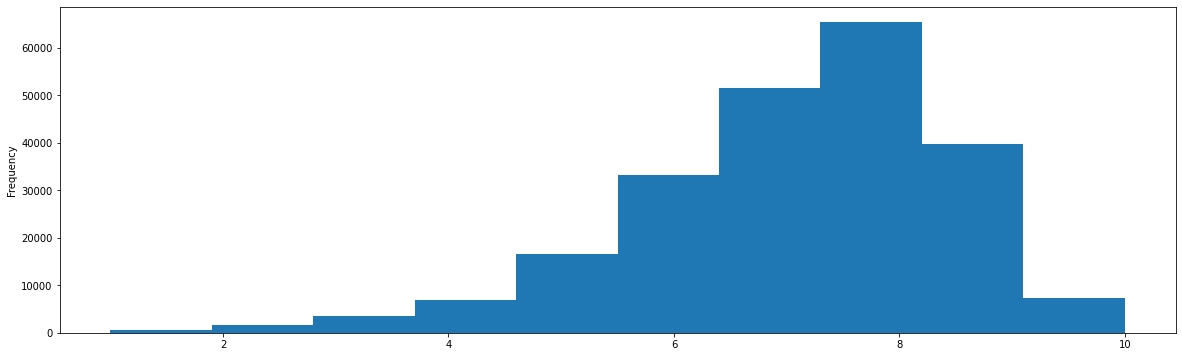

In [89]:
song_imdb_merge.averageRating.plot(kind='hist') #most of the rating has happened in the range of 6 to 9 and hence, we can take averageRating greater than 5

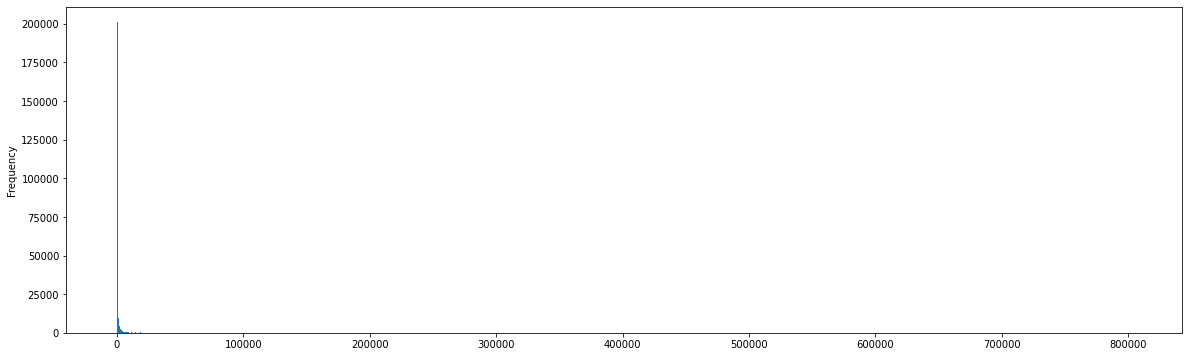

In [94]:
song_imdb_merge.numVotes.plot(bins=1000,kind='hist') # This means there are 800 data points within every bin (total no of bins=1000=no of rows in the dataset)
# What we see here is, the peak is in the first few bins, plotly express below will give a clear view

In [103]:
fig = px.histogram(song_imdb_merge,x=song_imdb_merge.numVotes,nbins=100000,title='Plot Frequency')
fig.show()
#in IMDb Voting, rating dataset for the matching songs in MillionSongs Dataset significant no of votes are in this range
#192K counts in 0-499 Votes -> 0-99 Votes has 152K counts -> 100-199 Votes has 18.12K counts
#12.6K counts in 500-999 Votes
#
#So this means, we should consider numVotes < 1000 for filtering

In [104]:
#numVotes distribution across songs
fig1 = px.line(song_imdb_merge,x=song_imdb_merge.index,y='numVotes',title='Plot Frequency')
fig1.show()

In [107]:
#playcount distribution across songs
fig2 = px.line(song_imdb_merge,x=song_imdb_merge.index,y='play_count',title='Plot Frequency')
fig2.show()

In [110]:
#histogram distribution across songs
fig3 = px.histogram(song_imdb_merge,x=song_imdb_merge.play_count,nbins=1000,title='Plot Frequency')
fig3.show()

In [136]:
# Simulation of above histogram through code
cnt=[]
playcnt=[10,20,30,40,50,60,70,80,90,100,150,200,300,400,500,1000]
for i in range(len(playcnt)):
  cnt.append(song_imdb_merge[(song_imdb_merge.play_count>playcnt[i]-playcnt[i-1])&(song_imdb_merge.play_count<playcnt[i])].count()['song_id'])

dfplaycnt=pd.DataFrame({'playcount':playcnt,'counts':cnt}).set_index('playcount')
dfplaycnt

counts
playcount        
10         120699
20          49311
30          71513
40          82043
50          86655
60          89781
70          91433
80          92772
90          93638
100         94162
150          8296
200          8695
300          1757
400          1846
500          1926
1000           18

In [137]:
fig4 = px.line(dfplaycnt,x=dfplaycnt.index,y='counts',title='Plot playcounts bin')
fig4.show()
#This shows interesing graph playcount 20 DIPS drastically that means we can consider play_count>20 

In [143]:
# Simulation of above histogram through code for numVotes
cnt=[]
numvotes=[10,20,30,40,50,60,70,80,90,100,150,200,300,400,500,1000,10000,100000,200000,300000,500000,800000,1000000]
for i in range(len(numvotes)):
  cnt.append(song_imdb_merge[(song_imdb_merge.numVotes>numvotes[i]-numvotes[i-1])&(song_imdb_merge.numVotes<numvotes[i])].count()['song_id'])

dfnumvotes=pd.DataFrame({'numvotes':numvotes,'counts':cnt}).set_index('numvotes')
dfnumvotes

counts
numvotes        
10         52344
20         35229
30         54175
40         65162
50         72525
60         79483
70         85393
80         90120
90         93698
100        96748
150        34009
200        41537
300        28103
400        33178
500        36982
1000       12570
10000        452
100000        34
200000       347
300000       549
500000       379
800000       209
1000000      429

In [144]:
fig5 = px.line(dfnumvotes,x=dfnumvotes.index,y='counts',title='Plot numVotes bin')
fig5.show()
#This shows interesting graph of IMDb rating->numVotes graph watch bins 10 to 1000, numVotes peaks at 100th bin with 96.7K counts. 
#numVotes is “No of votes garnered by the title”

# Content Based Filtering

In content based recommendation system, we would be using these parameters to recommend a song

- Artist Name
- Gender
- Release

Text data generally is very noisy i.e. present pronunciation, stopwords, non-ascii characters makes it very noisy. So we will first need to pre-process the text. And then we will generate features from the text to compute similarities between the texts/reviews.
